In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power
from mgcpy.benchmarks.simulations import linear_sim, quad_sim, ubern_sim, exp_sim, w_sim, joint_sim, spiral_sim
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr

In [3]:
def compute_distance_matrix(data_matrix_X, data_matrix_Y):
    # obtain the pairwise distance matrix for X and Y
    dist_mtx_X = squareform(pdist(data_matrix_X, metric='euclidean'))
    dist_mtx_Y = squareform(pdist(data_matrix_Y, metric='euclidean'))
    return (dist_mtx_X, dist_mtx_Y)

In [4]:
def power_vs_dimension(independence_test, simulation_type, dim_range):
    '''
    Generate power of an independence test given a simulation for a range of dimensions
    
    :param independence_test: an independence_test object
    :param simulation_type: a simulation function from mgcpy.benchmarks.simulations
    :param dim_range: the upper end of the range of dimension
    :return: power for each dimension
    '''
    estimated_power = np.zeros(dim_range)
    for d in range(1, dim_range+1):
        estimated_power[d-1] = power(independence_test, simulation_type, num_samples=100, num_dimensions=d)
    return estimated_power

In [8]:
def compute_all_power(simulation_type, dim_range):
    '''
    Plot power curve for each independence test as dimension increases 
    '''

    '''
    Initialize all independence test objects
    Data matrices initialized to np.nan, because in power computation each repeats involves generating new samples
    '''
    mcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mcorr')
    dcorr = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='dcorr')
    mantel = DCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan,
                  compute_distance_matrix=compute_distance_matrix, corr_type='mantel')
    mgc = MGC(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    rv_corr = RVCorr(data_matrix_X=np.nan, data_matrix_Y=np.nan, compute_distance_matrix=compute_distance_matrix)
    
    independence_tests = {'MGC': mgc, 'MCorr': mcorr, 'DCorr': dcorr, 'Mantel': mantel, 'RV Corr': rv_corr}
    power_results = {}
    
    for name, test in independence_tests.items():
        power = power_vs_dimension(test, simulation_type, dim_range)
        power_results[name] = power
    
    return power_results

In [9]:
def plot_power_curve(power_results, simulation_name):
    '''
    Plot the power of each independence test relative to mgc
    '''
    mgc_power = power_results['MGC']

    for name, power in power_results.items():     
        plt.plot(power-mgc_power, label=name)
   
    plt.xlabel('Dimensions')
    plt.ylabel('Power')
    plt.legend()
    plt.gca().set_xlim(1, mgc_power.shape[0]+1)
    plt.xticks(np.arange(1, mgc_power.shape[0]+1))
    plt.title('Power \n Data: {} Simulation, 100 samples, noise=0'.format(simulation_name))
    plt.show()

In [ ]:
%%time
power_results = compute_all_power(quad_sim, 3)

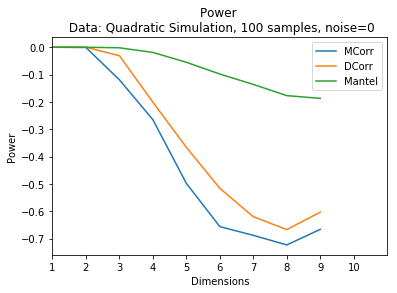

CPU times: user 23min 24s, sys: 4.02 s, total: 23min 28s
Wall time: 23min 37s


In [6]:
%%time
plot_power_curve(quad_sim, 10, 'Quadratic')